# Image Captioning

---

<a id='step1'></a>
## Step 1: Get Data Loader for Test Dataset

In [2]:
import sys
sys.path.append('cocoapi/PythonAPI')
from pycocotools.coco import COCO
from data_loader import get_loader
from torchvision import transforms

transform_test = transforms.Compose([
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225))
])

data_loader = get_loader(transform=transform_test,    
                         mode='test')

Vocabulary successfully loaded from vocab.pkl file!


<a id='step2'></a>
## Step 2: Load Trained Models

In [7]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
import os
import torch
from model import EncoderCNN, DecoderRNN

encoder_file = 'encoder-3.pkl'
decoder_file = 'decoder-3.pkl'
embed_size = 256 
hidden_size = 512
vocab_size = len(data_loader.dataset.vocab)
encoder = EncoderCNN(embed_size)
encoder.eval()
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)
decoder.eval()
encoder.load_state_dict(
    torch.load(os.path.join('./models', encoder_file), map_location='cpu'),
    strict=False
)
state_dict = torch.load(os.path.join('./models', decoder_file), map_location='cpu')
state_dict.pop('linear.weight', None)
state_dict.pop('linear.bias', None)

decoder.load_state_dict(state_dict, strict=False)


encoder.to(device)
decoder.to(device)

DecoderRNN(
  (word_embeddings): Embedding(9947, 256)
  (lstm): LSTM(256, 512, batch_first=True)
  (linear): Linear(in_features=512, out_features=9947, bias=True)
)

<a id='step3'></a>
## Step 3: Finish the Sampler in Decoder CNN

In [ ]:
from PIL import Image

transform_test = transforms.Compose([
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

custom_image_path = "images/im1.jpg"  
image = Image.open(custom_image_path).convert("RGB")
image = transform_test(image).unsqueeze(0).to(device)
encoder.eval()
decoder.eval()
with torch.no_grad():
    features = encoder(image).unsqueeze(1)
    output = decoder.sample(features)  
    print('example output:', output)
    assert isinstance(output, list), "Output needs to be a Python list"
    assert all(isinstance(x, int) for x in output), "Output should be a list of integers"
    assert all(x in data_loader.dataset.vocab.idx2word for x in output), \
        "Each entry in the output needs to correspond to an integer that indicates a token in the vocabulary"

example output: [2334, 6357, 639, 639, 639, 639, 639, 639, 639, 639, 639, 853, 639, 853, 639, 853, 469, 853, 1450, 4480]


<a id='step4'></a>
## Step 4: Clean up the Captions

In [16]:
def clean_sentence(output):
    """
    Clean predicted sentence from start and end token
    """
    parts = [data_loader.dataset.vocab.idx2word[i] for i in output 
             if data_loader.dataset.vocab.idx2word[i] not in ['<start>', '<end>']]
    sentence = " ".join(parts).capitalize() 
    return sentence

In [ ]:
sentence = clean_sentence(output)
print('example sentence:', sentence)
assert type(sentence)==str, 'Sentence needs to be a Python string!'

example sentence: A man cutting a cake with a knife .


<a id='step5'></a>
## Step 5: Generate predictions

In [21]:
def get_prediction():
    import os
    from PIL import Image
    import matplotlib.pyplot as plt  

    images_folder = "images"  # path to your image folder

    for filename in os.listdir(images_folder):
        if filename.lower().endswith((".jpg", ".jpeg", ".png")):
            image_path = os.path.join(images_folder, filename)

            orig_image = Image.open(image_path).convert("RGB")
            image = transform_test(orig_image).unsqueeze(0).to(device)

            plt.imshow(orig_image)
            plt.title(f'Sample Image: {filename}')
            plt.axis('off')
            plt.show()

            features = encoder(image).unsqueeze(1)
            output = decoder.sample(features)
            sentence = clean_sentence(output)
            print(sentence)


### The model performed satisfactorily

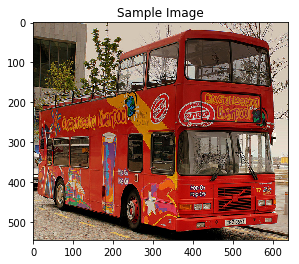

A red and white bus parked next to a building .


In [46]:
get_prediction()

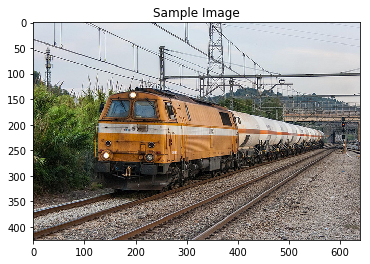

A train is traveling down the tracks near a station . .


In [33]:
get_prediction()